In [2]:
import pandas as pd
import numpy as np
import os
import torch

from Model.Query2Label_pl import Query2Label_pl


model_dir = "/mnt/d/ML/Kaggle/CAFA6-new/downloads/test/"

In [6]:
# Load configs
import json
with open(os.path.join(model_dir, "configs.json"), "r") as f:
    configs = json.load(f)

model_configs = configs["model_configs"]
print("Model configs:", model_configs)

Model configs: {'token_dim': 512, 'num_tokens': 64, 'max_terms': 64, 'nheads': 8, 'num_encoder_layers': 1, 'num_decoder_layers': 3, 'dim_feedforward': 2048, 'dropout': 0.3, 'use_positional_encoding': False}


In [7]:
# Load model from checkpoint - automatically find the best checkpoint
import glob
import re

# Find all checkpoint files in the model directory
checkpoint_files = glob.glob(os.path.join(model_dir, "*.ckpt"))

if not checkpoint_files:
    raise FileNotFoundError(f"No checkpoint files found in {model_dir}")

# Parse metric values from checkpoint filenames and find the best one
best_checkpoint = None
best_metric = -float('inf')

for ckpt_file in checkpoint_files:
    # Extract metric value from filename (e.g., "epoch=07-val_f1_macro_go=0.1284.ckpt" -> 0.1284)
    match = re.search(r'=([0-9.]+)\.ckpt$', ckpt_file)
    if match:
        metric_value = float(match.group(1))
        if metric_value > best_metric:
            best_metric = metric_value
            best_checkpoint = ckpt_file

if best_checkpoint is None:
    # If no metric found in filename, use the first checkpoint
    best_checkpoint = checkpoint_files[0]
    print(f"Warning: Could not parse metrics from filenames. Using: {os.path.basename(best_checkpoint)}")
else:
    print(f"Found best checkpoint with metric {best_metric:.4f}: {os.path.basename(best_checkpoint)}")

checkpoint_path = best_checkpoint

# Load the model using Lightning's load_from_checkpoint
model = Query2Label_pl.load_from_checkpoint(
    checkpoint_path,
    strict=False  # In case there are minor mismatches
)

# Set model to evaluation mode
model.eval()
print("Model loaded successfully!")
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

Found best checkpoint with metric 0.1284: epoch=07-val_f1_macro_go=0.1284.ckpt


/home/tan/miniconda3/envs/cafa6/lib/python3.12/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.6


Model loaded successfully!
Model has 15797312 parameters


In [8]:
# Build and load tokenizer
from Utils.tokenizer import EmbedTokenizer

# Get embedding dimension from configs
token_d = int(model_configs.get('token_dim', 512))
num_tokens = int(model_configs.get('num_tokens', 64))

# We'll determine embedding_dim from data later, for now create tokenizer
# The tokenizer will be properly initialized when we load its state
tokenizer = EmbedTokenizer(D=1280, d=token_d, N=num_tokens)  # ESM-650M dim is 1280

# Load tokenizer state
tokenizer_path = os.path.join(model_dir, "tokenizer_state_dict.pt")
tokenizer_state = torch.load(tokenizer_path, map_location='cpu')
tokenizer.load_state_dict(tokenizer_state)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = tokenizer.to(device)
tokenizer.eval()

print(f"Tokenizer loaded successfully on {device}!")
# print(f"Tokenizer: D={tokenizer.D}, d={tokenizer.d}, N={tokenizer.N}")

Tokenizer loaded successfully on cuda!


In [9]:
# Define data paths
data_paths = {
    "knn_terms_df":         "/mnt/d/ML/Kaggle/CAFA6-new/uniprot/diamond_knn_predictions.parquet",
    "train_terms_df":       "/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_terms.tsv",
    "go_obo_path":          "/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/go-basic.obo",
    "features_embeds_path": "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/esm_t33_650M/train_embeds.npy",
    "features_ids_path":    "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/esm_t33_650M/train_ids.npy",
    "go_embeds_paths":      "/mnt/d/ML/Kaggle/CAFA6-new/uniprot/go_embeddings.pkl"
}

print("Data paths configured")

Data paths configured


In [10]:
# Prepare data using the prepare_data function
from Dataset.Utils import prepare_data

max_terms = model_configs.get('max_terms', 64)
aspect = configs['training_configs'].get('aspect', 'P')

print(f"Preparing data with max_terms={max_terms}, aspect={aspect}...")
data = prepare_data(data_paths, max_terms=max_terms, aspect=aspect)
print(f"Data preparation complete!")
print(f"Number of sequences: {len(data['seq_2_terms'])}")
print(f"Number of GO embeddings: {len(data['go_embeds'])}")

Preparing data with max_terms=64, aspect=P...
Padding terms_predicted with GO graph neighbors...
Padding complete. Average terms per row: 63.42
Data preparation complete!
Number of sequences: 53315
Number of GO embeddings: 40122


In [12]:
# Check if all true predictions from train_terms_all are present in terms_predicted
def check_coverage(row):
    """Check what percentage of train_terms_all are in terms_predicted"""
    # Check if train_terms_all is None or empty list
    if row['terms_true'] is None or (isinstance(row['terms_true'], list) and len(row['terms_true']) == 0):
        return None
    
    train_set = set(row['terms_true'])
    pred_set = set(row['terms_predicted'])
    
    # Find terms in train_terms_all that are in terms_predicted
    covered_terms = train_set.intersection(pred_set)
    
    # Calculate coverage percentage
    coverage = len(covered_terms) / len(train_set) * 100 if len(train_set) > 0 else 0
    
    return {
        'total_train_terms': len(train_set),
        'covered_terms': len(covered_terms),
        'missing_terms': len(train_set) - len(covered_terms),
        'coverage_pct': coverage,
        'missing_term_list': list(train_set - covered_terms)
    }

# Apply the check
coverage_results = data['seq_2_terms'].apply(check_coverage, axis=1)
coverage_df = pd.DataFrame(coverage_results.tolist())

# Combine with original data
analysis_df = pd.concat([data['seq_2_terms'], coverage_df], axis=1)
print("=== Coverage Analysis ===")
print(f"\nOverall Statistics:")
print(f"Average coverage: {coverage_df['coverage_pct'].mean():.2f}%")
print(f"Median coverage: {coverage_df['coverage_pct'].median():.2f}%")
print(f"Min coverage: {coverage_df['coverage_pct'].min():.2f}%")
print(f"Max coverage: {coverage_df['coverage_pct'].max():.2f}%")
print(f"\nRows with 100% coverage: {(coverage_df['coverage_pct'] == 100).sum()} / {len(coverage_df)}")
print(f"Rows with 0% coverage: {(coverage_df['coverage_pct'] == 0).sum()} / {len(coverage_df)}")
print(f"\nAverage missing terms per row: {coverage_df['missing_terms'].mean():.2f}")
print(f"Total train terms checked: {coverage_df['total_train_terms'].sum()}")
print(f"Total covered terms: {coverage_df['covered_terms'].sum()}")
print(f"Total missing terms: {coverage_df['missing_terms'].sum()}")

=== Coverage Analysis ===

Overall Statistics:
Average coverage: 80.68%
Median coverage: 100.00%
Min coverage: 0.00%
Max coverage: 100.00%

Rows with 100% coverage: 36822 / 53315
Rows with 0% coverage: 3962 / 53315

Average missing terms per row: 1.32
Total train terms checked: 235392
Total covered terms: 164750
Total missing terms: 70642


In [13]:
# Create dataset and dataloader
from Dataset.EmbeddingsDataset import EmbeddingsDataset, collate_tokenize, PrefetchLoader
from torch.utils.data import DataLoader

# Use all data for inference
all_indices = list(range(len(data['seq_2_terms'])))
test_dataset = EmbeddingsDataset(data, oversample_indices=all_indices)

batch_size = configs['training_configs'].get('batch_size', 64)
num_workers = configs['training_configs'].get('num_workers', 0)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    collate_fn=lambda b: collate_tokenize(b)
)

# Wrap with PrefetchLoader for GPU tokenization
test_loader = PrefetchLoader(test_loader, device, tokenizer=tokenizer)

print(f"Dataset created with {len(test_dataset)} samples")
print(f"Batch size: {batch_size}")

Dataset created with 53315 samples
Batch size: 64


In [14]:
# Run inference and generate predictions
from tqdm.notebook import tqdm

model = model.to(device)
model.eval()

# Store predictions and labels as arrays (not dicts)
predictions_list = []
true_list = []
print(f"Running inference on {len(test_dataset)} samples...")

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i % 50 == 0:
            print(f"Processing batch {i} / {len(test_loader)}")
        
        x = batch['go_embed']
        f = batch['feature']
        true_labels = batch['label']
        
        # Forward pass
        logits = model(x, f)
        probs = torch.sigmoid(logits)
        
        # Move to CPU and store as numpy arrays
        probs_cpu = probs.cpu().numpy()
        labels_cpu = true_labels.cpu().numpy()
        
        # Append arrays (not dicts!)
        predictions_list.append(probs_cpu)
        true_list.append(labels_cpu)
        
        # Free memory
        del logits, probs, probs_cpu, labels_cpu, x, f

print(f"\nInference complete! Processed {len(predictions_list)} batches")

Running inference on 53315 samples...
Processing batch 0 / 834
Processing batch 50 / 834
Processing batch 100 / 834
Processing batch 150 / 834
Processing batch 200 / 834
Processing batch 250 / 834
Processing batch 300 / 834
Processing batch 350 / 834
Processing batch 400 / 834
Processing batch 450 / 834
Processing batch 500 / 834
Processing batch 550 / 834
Processing batch 600 / 834
Processing batch 650 / 834
Processing batch 700 / 834
Processing batch 750 / 834
Processing batch 800 / 834

Inference complete! Processed 834 batches


In [15]:
predictions_list = np.vstack(predictions_list)
true_list = np.vstack(true_list)

print(f"Predictions array shape: {predictions_list.shape}")
print(f"True labels array shape: {true_list.shape}")

Predictions array shape: (53315, 64)
True labels array shape: (53315, 64)


In [ ]:
# Apply GO hierarchy constraints to predictions
def apply_go_hierarchy_constraints(predictions_array, terms_lists, go_graph):
    """
    Apply GO hierarchy constraints: parent terms should have scores >= child terms.
    For each protein, propagate scores up the hierarchy.
    
    Args:
        predictions_array: (N, M) array of prediction scores
        terms_lists: List of N term lists (each with M terms)
        go_graph: NetworkX graph with GO term hierarchy
    
    Returns:
        constrained_predictions: (N, M) array with hierarchy constraints applied
    """
    import networkx as nx
    
    constrained_predictions = predictions_array.copy()
    
    print("Applying GO hierarchy constraints...")
    for i in range(len(predictions_array)):
        terms = terms_lists[i]
        scores = predictions_array[i].copy()
        
        # Create term to index mapping
        term_to_idx = {term: idx for idx, term in enumerate(terms)}
        
        # For each term, propagate score to all ancestors
        for term_idx, term in enumerate(terms):
            if term not in go_graph:
                continue
                
            term_score = scores[term_idx]
            
            # Get all ancestors (parent terms)
            try:
                ancestors = nx.ancestors(go_graph, term)
            except:
                # If term not in graph or no ancestors, skip
                continue
            
            # Propagate score to ancestors: each ancestor should have at least this child's score
            for ancestor in ancestors:
                if ancestor in term_to_idx:
                    ancestor_idx = term_to_idx[ancestor]
                    # Update ancestor score to be at least as high as child score
                    scores[ancestor_idx] = max(scores[ancestor_idx], term_score)
        
        constrained_predictions[i] = scores
    
    print("GO hierarchy constraints applied!")
    return constrained_predictions

# Apply constraints to predictions
predictions_list_constrained = apply_go_hierarchy_constraints(
    predictions_list, 
    terms_list, 
    data['go_graph']
)

print(f"Original predictions shape: {predictions_list.shape}")
print(f"Constrained predictions shape: {predictions_list_constrained.shape}")

# Check how many predictions changed
changed_predictions = np.sum(predictions_list_constrained != predictions_list)
total_predictions = predictions_list.size
print(f"\nPredictions modified: {changed_predictions:,} / {total_predictions:,} ({changed_predictions/total_predictions*100:.2f}%)")

# Show example of changes
sample_idx = 104
print(f"\nExample protein (index {sample_idx}):")
print(f"  Original score range: [{predictions_list[sample_idx].min():.4f}, {predictions_list[sample_idx].max():.4f}]")
print(f"  Constrained score range: [{predictions_list_constrained[sample_idx].min():.4f}, {predictions_list_constrained[sample_idx].max():.4f}]")
diff = predictions_list_constrained[sample_idx] - predictions_list[sample_idx]
print(f"  Number of terms with increased scores: {np.sum(diff > 0)}")

In [ ]:
# Visualize the effect of hierarchy constraints
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot example protein before and after
sample_idx = 104
x_vals = np.arange(len(predictions_list[sample_idx]))

axes[0].plot(x_vals, predictions_list[sample_idx], alpha=0.7, label='Original', linewidth=1.5)
axes[0].plot(x_vals, predictions_list_constrained[sample_idx], alpha=0.7, label='Constrained', linewidth=1.5)
axes[0].scatter(x_vals, true_list[sample_idx], color='red', s=30, alpha=0.5, label='Ground Truth', marker='x')
axes[0].set_xlabel('Term Index', fontsize=11)
axes[0].set_ylabel('Prediction Score', fontsize=11)
axes[0].set_title(f'Example Protein (index {sample_idx}): Before vs After Hierarchy Constraints', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot distribution of score changes
score_changes = (predictions_list_constrained - predictions_list).flatten()
score_increases = score_changes[score_changes > 0]

axes[1].hist(score_increases, bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Score Increase', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Distribution of Score Increases\n({len(score_increases):,} terms affected)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axvline(score_increases.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {score_increases.mean():.4f}')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nScore increase statistics:")
print(f"  Mean increase: {score_increases.mean():.4f}")
print(f"  Median increase: {np.median(score_increases):.4f}")
print(f"  Max increase: {score_increases.max():.4f}")

In [ ]:
# Compare metrics: Original vs Hierarchy-Constrained predictions
print("="*80)
print("COMPARISON: Original vs Hierarchy-Constrained Predictions")
print("="*80)

# Create DataFrames from constrained predictions
pred_df_constrained, _ = create_topk_predictions_df(
    predictions_list_constrained, true_list, entry_ids_list, terms_list, top_k=None
)

print("\n--- Original Predictions (No Hierarchy Constraints) ---")
metrics_original = compute_fmax_topk(pred_df_full, gt_df, ia_df=ia_df)

print("\n--- Hierarchy-Constrained Predictions ---")
metrics_constrained = compute_fmax_topk(pred_df_constrained, gt_df, ia_df=ia_df)

# Create comparison table
hierarchy_comparison_data = {
    'Method': ['Original', 'Hierarchy-Constrained'],
    'Precision': [metrics_original['precision'], metrics_constrained['precision']],
    'Recall': [metrics_original['recall'], metrics_constrained['recall']],
    'F1': [metrics_original['f1'], metrics_constrained['f1']],
    'TP': [metrics_original['tp'], metrics_constrained['tp']],
    'FP': [metrics_original['fp'], metrics_constrained['fp']],
    'FN': [metrics_original['fn'], metrics_constrained['fn']]
}

hierarchy_comparison_df = pd.DataFrame(hierarchy_comparison_data)
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(hierarchy_comparison_df.to_string(index=False))

# Calculate improvements
precision_improvement = metrics_constrained['precision'] - metrics_original['precision']
recall_improvement = metrics_constrained['recall'] - metrics_original['recall']
f1_improvement = metrics_constrained['f1'] - metrics_original['f1']

print(f"\n{'='*80}")
print("IMPROVEMENTS")
print(f"{'='*80}")
print(f"Precision: {precision_improvement:+.4f} ({precision_improvement/metrics_original['precision']*100:+.2f}%)")
print(f"Recall: {recall_improvement:+.4f} ({recall_improvement/metrics_original['recall']*100:+.2f}%)")
print(f"F1: {f1_improvement:+.4f} ({f1_improvement/metrics_original['f1']*100:+.2f}%)")

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

metrics_to_plot = ['Precision', 'Recall', 'F1']
x = np.arange(len(metrics_to_plot))
width = 0.35

original_vals = [metrics_original['precision'], metrics_original['recall'], metrics_original['f1']]
constrained_vals = [metrics_constrained['precision'], metrics_constrained['recall'], metrics_constrained['f1']]

bars1 = ax.bar(x - width/2, original_vals, width, label='Original', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, constrained_vals, width, label='Hierarchy-Constrained', alpha=0.8, color='forestgreen')
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Original vs Hierarchy-Constrained Predictions', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

# Add value labels and improvement indicators
for i, (orig_val, const_val) in enumerate(zip(original_vals, constrained_vals)):
    ax.text(i - width/2, orig_val + 0.02, f'{orig_val:.4f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, const_val + 0.02, f'{const_val:.4f}', ha='center', va='bottom', fontsize=9)
    
    # Add improvement arrow and value
    improvement = const_val - orig_val
    if abs(improvement) > 0.0001:
        mid_x = i
        mid_y_start = orig_val
        mid_y_end = const_val
        arrow_props = dict(arrowstyle='->', lw=1.5, color='red' if improvement > 0 else 'orange')
        ax.annotate('', xy=(mid_x, mid_y_end), xytext=(mid_x, mid_y_start),
                   arrowprops=arrow_props)
        ax.text(mid_x + 0.15, (mid_y_start + mid_y_end) / 2, 
               f'{improvement:+.4f}', fontsize=8, color='red' if improvement > 0 else 'orange',
               fontweight='bold')

plt.tight_layout()
plt.show()

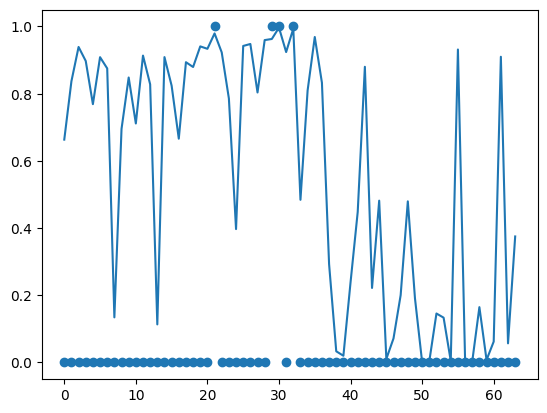

In [16]:
import matplotlib.pyplot as plt 
i = 104
plt.plot(np.arange(predictions_list[i].shape[0]), predictions_list[i])
plt.scatter(np.arange(true_list[i].shape[0]), true_list[i])

In [17]:
# Rebuild predictions and ground truth DataFrames from arrays
# We need to match predictions back to EntryIDs and terms

entry_ids_list = []
terms_list = []

for idx in all_indices:
    row = data['seq_2_terms'].iloc[idx]
    entry_ids_list.append(row['qseqid'])
    terms_list.append(row['terms_predicted'])

print(f"Collected {len(entry_ids_list)} entries with their terms")
print(f"Predictions shape: {predictions_list.shape}")
print(f"True labels shape: {true_list.shape}")

Collected 53315 entries with their terms
Predictions shape: (53315, 64)
True labels shape: (53315, 64)


In [18]:
# Function to create predictions DataFrame with top-k filtering
def create_topk_predictions_df(predictions_array, true_array, entry_ids, terms_lists, top_k=None):
    """
    Create predictions and ground truth DataFrames from arrays.
    
    Args:
        predictions_array: (N, M) array of prediction scores
        true_array: (N, M) array of true labels (0 or 1)
        entry_ids: List of N entry IDs
        terms_lists: List of N term lists (each with M terms)
        top_k: If provided, only keep top-k predictions per sample
    
    Returns:
        predictions_df: DataFrame with ['EntryID', 'term', 'score']
        ground_truth_df: DataFrame with ['EntryID', 'term']
    """
    pred_records = []
    gt_records = []
    
    for i in range(len(entry_ids)):
        entry_id = entry_ids[i]
        terms = terms_lists[i]
        scores = predictions_array[i]
        labels = true_array[i]
        
        # Sort by score descending and get top-k if specified
        if top_k is not None:
            sorted_indices = np.argsort(scores)[::-1][:top_k]
        else:
            sorted_indices = np.arange(len(scores))
        
        # Add predictions (only top-k if specified)
        for idx in sorted_indices:
            pred_records.append({
                'EntryID': entry_id,
                'term': terms[idx],
                'score': float(scores[idx])
            })
        
        # Add ground truth (all true labels)
        for idx in range(len(terms)):
            if labels[idx] > 0.5:  # True label
                gt_records.append({
                    'EntryID': entry_id,
                    'term': terms[idx]
                })
    
    predictions_df = pd.DataFrame(pred_records)
    ground_truth_df = pd.DataFrame(gt_records)
    
    return predictions_df, ground_truth_df

# Test with no filtering first
pred_df_full, gt_df = create_topk_predictions_df(
    predictions_list, true_list, entry_ids_list, terms_list, top_k=None
)

print(f"Full predictions: {len(pred_df_full)} records")
print(f"Ground truth: {len(gt_df)} records")
print(f"Unique proteins in predictions: {pred_df_full['EntryID'].nunique()}")
print(f"Unique proteins in ground truth: {gt_df['EntryID'].nunique()}")

Full predictions: 3412160 records
Ground truth: 164750 records
Unique proteins in predictions: 53315
Unique proteins in ground truth: 49353


In [19]:
ia_df = pd.read_csv("/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/IA.tsv", sep="\t", header=None)
ia_df.columns = ['terms', 'ia']
ia_df

,terms,ia
0,GO:0000001,0.000000
1,GO:0000002,2.849666
2,GO:0000011,0.137504
3,GO:0000012,6.038630
4,GO:0000017,0.514573
...,...,...
40117,GO:2001083,0.000000
40118,GO:2001084,0.000000
40119,GO:2001085,0.000000
40120,GO:2001147,6.882643


In [20]:
# Compute F-max function (adapted from test.py)
def compute_fmax_topk(predictions_df, ground_truth_df, ia_df=None):
    """
    Compute macro F1, precision, and recall for predictions.
    Calculates metrics for each entry individually, then averages them.
    
    Args:
        predictions_df: DataFrame with columns ['EntryID', 'term', 'score']
        ground_truth_df: DataFrame with columns ['EntryID', 'term']
        ia_df: Optional DataFrame with columns ['terms', 'ia'] for IA-weighted metrics.
               If provided, metrics will be weighted by IA scores.
    
    Returns:
        dict with f1, precision, recall (macro-averaged)
    """
    # Build IA dictionary if provided
    ia_dict = {}
    use_ia_weighting = ia_df is not None
    if use_ia_weighting:
        ia_dict = dict(zip(ia_df['terms'], ia_df['ia']))
        print(f"Using IA weighting with {len(ia_dict)} terms")
    
    print("Building ground truth dictionary...")
    # Build ground truth set per EntryID
    gt_dict = {}
    for entry_id, group in ground_truth_df.groupby('EntryID'):
        gt_dict[entry_id] = set(group['term'].values)
    
    # Build prediction dict
    pred_dict = {}
    for entry_id, group in predictions_df.groupby('EntryID'):
        pred_dict[entry_id] = set(group['term'].values)
    
    # Get all entry IDs
    all_entries = set(gt_dict.keys()) | set(pred_dict.keys())
    
    # Calculate per-entry metrics for macro averaging
    precisions = []
    recalls = []
    f1_scores = []
    
    total_tp = 0.0
    total_fp = 0.0
    total_fn = 0.0
    
    for entry_id in all_entries:
        true_terms = gt_dict.get(entry_id, set())
        pred_terms = pred_dict.get(entry_id, set())
        
        if use_ia_weighting:
            # Weighted by IA scores
            tp = sum(ia_dict.get(term, 0.0) for term in (true_terms & pred_terms))
            fp = sum(ia_dict.get(term, 0.0) for term in (pred_terms - true_terms))
            fn = sum(ia_dict.get(term, 0.0) for term in (true_terms - pred_terms))
        else:
            # Unweighted (count)
            tp = len(true_terms & pred_terms)
            fp = len(pred_terms - true_terms)
            fn = len(true_terms - pred_terms)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        # Calculate per-entry metrics
        entry_precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        entry_recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        entry_f1 = 2 * entry_precision * entry_recall / (entry_precision + entry_recall) if (entry_precision + entry_recall) > 0 else 0.0
        
        precisions.append(entry_precision)
        recalls.append(entry_recall)
        f1_scores.append(entry_f1)
    
    # Macro-average: average across all entries
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)
    
    metric_type = "IA-weighted" if use_ia_weighting else "Unweighted"
    print(f"Total {metric_type} TP: {total_tp:.2f}, FP: {total_fp:.2f}, FN: {total_fn:.2f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    
    return {
        'f1': macro_f1,
        'precision': macro_precision,
        'recall': macro_recall,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn
    }

# Test with full predictions
print("=== Metrics with ALL predictions ===")
metrics_full = compute_fmax_topk(pred_df_full, gt_df)

=== Metrics with ALL predictions ===
Building ground truth dictionary...
Total Unweighted TP: 164750.00, FP: 3247410.00, FN: 0.00
Macro Precision: 0.0483
Macro Recall: 0.9257
Macro F1: 0.0871


COMPARISON: Unweighted vs IA-Weighted Metrics

--- Unweighted Metrics ---
Building ground truth dictionary...
Total Unweighted TP: 164750.00, FP: 3247410.00, FN: 0.00
Macro Precision: 0.0483
Macro Recall: 0.9257
Macro F1: 0.0871

--- IA-Weighted Metrics ---
Using IA weighting with 40122 terms
Building ground truth dictionary...
Total IA-weighted TP: 196418.62, FP: 4851459.18, FN: 0.00
Macro Precision: 0.0410
Macro Recall: 0.8304
Macro F1: 0.0725

SUMMARY
Metric Type  Precision   Recall       F1            TP           FP  FN
 Unweighted   0.048283 0.925687 0.087138 164750.000000 3.247410e+06 0.0
IA-Weighted   0.040995 0.830442 0.072453 196418.615186 4.851459e+06 0.0


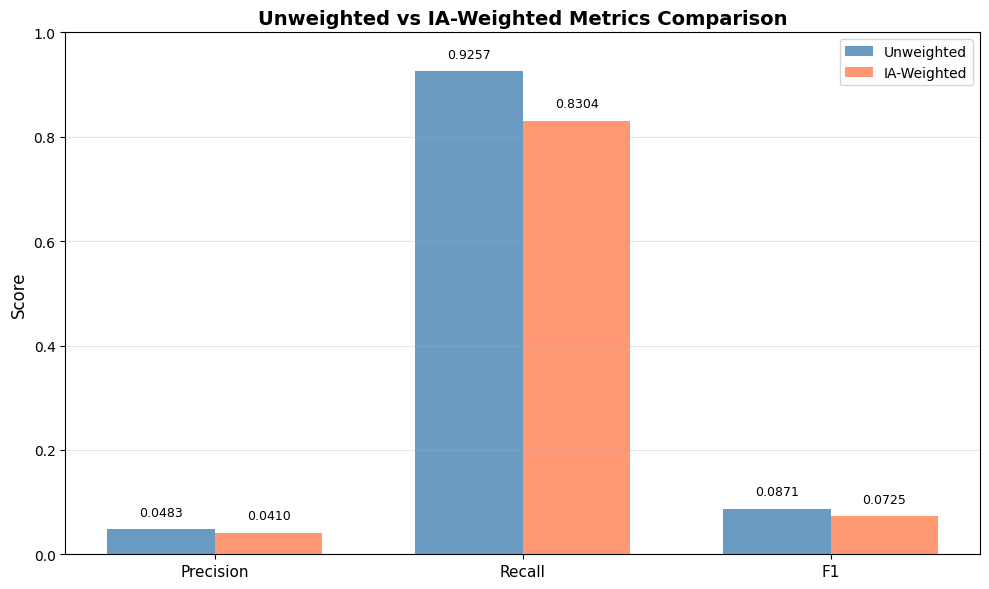

In [21]:
# Compare unweighted vs IA-weighted metrics
print("="*80)
print("COMPARISON: Unweighted vs IA-Weighted Metrics")
print("="*80)

print("\n--- Unweighted Metrics ---")
metrics_unweighted = compute_fmax_topk(pred_df_full, gt_df, ia_df=None)

print("\n--- IA-Weighted Metrics ---")
metrics_ia_weighted = compute_fmax_topk(pred_df_full, gt_df, ia_df=ia_df)

# Create comparison table
comparison_data = {
    'Metric Type': ['Unweighted', 'IA-Weighted'],
    'Precision': [metrics_unweighted['precision'], metrics_ia_weighted['precision']],
    'Recall': [metrics_unweighted['recall'], metrics_ia_weighted['recall']],
    'F1': [metrics_unweighted['f1'], metrics_ia_weighted['f1']],
    'TP': [metrics_unweighted['tp'], metrics_ia_weighted['tp']],
    'FP': [metrics_unweighted['fp'], metrics_ia_weighted['fp']],
    'FN': [metrics_unweighted['fn'], metrics_ia_weighted['fn']]
}

comparison_metrics_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(comparison_metrics_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

metrics_to_plot = ['Precision', 'Recall', 'F1']
x = np.arange(len(metrics_to_plot))
width = 0.35

unweighted_vals = [metrics_unweighted['precision'], metrics_unweighted['recall'], metrics_unweighted['f1']]
weighted_vals = [metrics_ia_weighted['precision'], metrics_ia_weighted['recall'], metrics_ia_weighted['f1']]

ax.bar(x - width/2, unweighted_vals, width, label='Unweighted', alpha=0.8, color='steelblue')
ax.bar(x + width/2, weighted_vals, width, label='IA-Weighted', alpha=0.8, color='coral')
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Unweighted vs IA-Weighted Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.0])

# Add value labels on bars
for i, (unw_val, w_val) in enumerate(zip(unweighted_vals, weighted_vals)):
    ax.text(i - width/2, unw_val + 0.02, f'{unw_val:.4f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, w_val + 0.02, f'{w_val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [22]:
# Analyze term frequencies in ground truth
term_freq = gt_df['term'].value_counts()
print(f"Total unique terms: {len(term_freq)}")
print(f"\nTop 5 most frequent (easy) classes:")
print(term_freq.head(5))
print(f"\nTop 5 least frequent (hard) classes:")
print(term_freq.tail(5))

# Get easy and hard term sets
easy_terms = set(term_freq.head(5).index)
hard_terms = set(term_freq.tail(5).index)

print(f"\nEasy terms: {easy_terms}")
print(f"Hard terms: {hard_terms}")

# Create top-k filtered predictions for easy/hard analysis
TOP_K_FOR_ANALYSIS = 16  # Set threshold - using top-16 predictions per protein
print(f"\n{'='*60}")
print(f"Creating TOP-{TOP_K_FOR_ANALYSIS} filtered predictions for analysis...")
print(f"{'='*60}")

pred_df_topk, _ = create_topk_predictions_df(
    predictions_list, true_list, entry_ids_list, terms_list, top_k=TOP_K_FOR_ANALYSIS
)

print(f"Filtered predictions: {len(pred_df_topk)} records")
print(f"Avg predictions per protein: {len(pred_df_topk) / pred_df_topk['EntryID'].nunique():.2f}")

Total unique terms: 14561

Top 5 most frequent (easy) classes:
term
GO:0006355    1302
GO:0045944    1124
GO:0045892    1004
GO:0006357     790
GO:0045893     691
Name: count, dtype: int64

Top 5 least frequent (hard) classes:
term
GO:0016076    1
GO:0120012    1
GO:0097037    1
GO:0106101    1
GO:0035683    1
Name: count, dtype: int64

Easy terms: {'GO:0045892', 'GO:0045944', 'GO:0045893', 'GO:0006357', 'GO:0006355'}
Hard terms: {'GO:0097037', 'GO:0016076', 'GO:0120012', 'GO:0106101', 'GO:0035683'}

Creating TOP-16 filtered predictions for analysis...
Filtered predictions: 853040 records
Avg predictions per protein: 16.00


In [23]:
# Function to compute metrics for specific term sets
def compute_metrics_for_terms(predictions_df, ground_truth_df, term_set, label=""):
    """
    Compute metrics for a specific set of terms.
    """
    # Filter to only the terms of interest
    pred_filtered = predictions_df[predictions_df['term'].isin(term_set)].copy()
    gt_filtered = ground_truth_df[ground_truth_df['term'].isin(term_set)].copy()
    
    print(f"\n=== {label} ===")
    print(f"Predictions: {len(pred_filtered)} records across {pred_filtered['EntryID'].nunique()} proteins")
    print(f"Ground truth: {len(gt_filtered)} records across {gt_filtered['EntryID'].nunique()} proteins")
    
    # Build ground truth dict
    gt_dict = {}
    for entry_id, group in gt_filtered.groupby('EntryID'):
        gt_dict[entry_id] = set(group['term'].values)
    
    # Build prediction dict
    pred_dict = {}
    for entry_id, group in pred_filtered.groupby('EntryID'):
        pred_dict[entry_id] = set(group['term'].values)
    
    # Get all entry IDs that have either predictions or ground truth for these terms
    all_entries = set(gt_dict.keys()) | set(pred_dict.keys())
    
    if len(all_entries) == 0:
        print("No entries found!")
        return None
    
    # Calculate per-entry metrics for macro averaging
    precisions = []
    recalls = []
    f1_scores = []
    
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    for entry_id in all_entries:
        true_terms = gt_dict.get(entry_id, set())
        pred_terms = pred_dict.get(entry_id, set())
        
        tp = len(true_terms & pred_terms)
        fp = len(pred_terms - true_terms)
        fn = len(true_terms - pred_terms)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
        # Calculate per-entry metrics (only for entries with predictions or ground truth)
        if (tp + fp) > 0 or (tp + fn) > 0:
            entry_precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            entry_recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            entry_f1 = 2 * entry_precision * entry_recall / (entry_precision + entry_recall) if (entry_precision + entry_recall) > 0 else 0.0
            
            precisions.append(entry_precision)
            recalls.append(entry_recall)
            f1_scores.append(entry_f1)
    
    # Macro-average
    macro_precision = np.mean(precisions) if precisions else 0.0
    macro_recall = np.mean(recalls) if recalls else 0.0
    macro_f1 = np.mean(f1_scores) if f1_scores else 0.0
    
    # Micro-average
    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0
    
    print(f"Total TP: {total_tp}, FP: {total_fp}, FN: {total_fn}")
    print(f"Macro - Precision: {macro_precision:.4f}, Recall: {macro_recall:.4f}, F1: {macro_f1:.4f}")
    print(f"Micro - Precision: {micro_precision:.4f}, Recall: {micro_recall:.4f}, F1: {micro_f1:.4f}")
    
    return {
        'label': label,
        'num_proteins': len(all_entries),
        'num_predictions': len(pred_filtered),
        'num_ground_truth': len(gt_filtered),
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'micro_precision': micro_precision,
        'micro_recall': micro_recall,
        'micro_f1': micro_f1,
        'tp': total_tp,
        'fp': total_fp,
        'fn': total_fn
    }

# Compute metrics for easy and hard classes
easy_metrics = compute_metrics_for_terms(pred_df_topk, gt_df, easy_terms, "EASY CLASSES (Top 5 Most Frequent)")
hard_metrics = compute_metrics_for_terms(pred_df_topk, gt_df, hard_terms, "HARD CLASSES (Top 5 Least Frequent)")


=== EASY CLASSES (Top 5 Most Frequent) ===
Predictions: 16813 records across 10628 proteins
Ground truth: 4911 records across 4039 proteins
Total TP: 2822, FP: 13991, FN: 2089
Macro - Precision: 0.1438, Recall: 0.2109, F1: 0.1585
Micro - Precision: 0.1678, Recall: 0.5746, F1: 0.2598

=== HARD CLASSES (Top 5 Least Frequent) ===
Predictions: 119 records across 119 proteins
Ground truth: 5 records across 5 proteins
Total TP: 4, FP: 115, FN: 1
Macro - Precision: 0.0333, Recall: 0.0333, F1: 0.0333
Micro - Precision: 0.0336, Recall: 0.8000, F1: 0.0645



COMPARISON: Easy vs Hard Classes
                              label  num_proteins  macro_precision  macro_recall  macro_f1  micro_precision  micro_recall  micro_f1
 EASY CLASSES (Top 5 Most Frequent)         11329         0.143793      0.210873  0.158515         0.167846      0.574628  0.259805
HARD CLASSES (Top 5 Least Frequent)           120         0.033333      0.033333  0.033333         0.033613      0.800000  0.064516


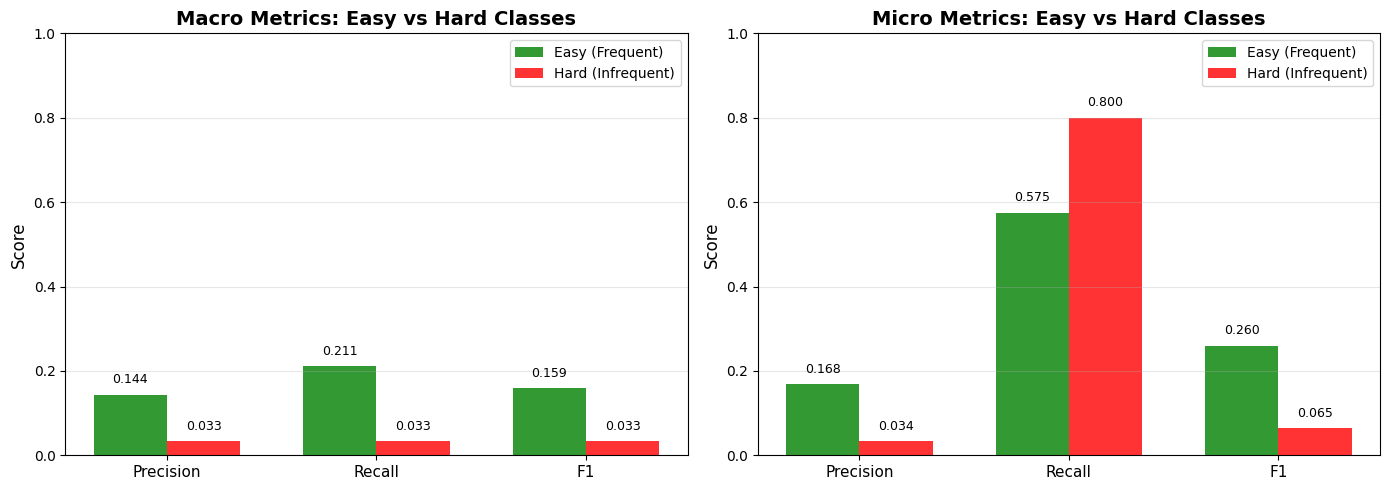


📊 Performance Gap (Macro F1): 0.1252
   Easy classes perform 375.5% better


In [24]:
# Create comparison table
comparison_df = pd.DataFrame([easy_metrics, hard_metrics])
print("\n" + "="*80)
print("COMPARISON: Easy vs Hard Classes")
print("="*80)
print(comparison_df[['label', 'num_proteins', 'macro_precision', 'macro_recall', 'macro_f1', 
                     'micro_precision', 'micro_recall', 'micro_f1']].to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Macro metrics
metrics_to_plot = ['macro_precision', 'macro_recall', 'macro_f1']
x = np.arange(len(metrics_to_plot))
width = 0.35

easy_vals = [easy_metrics[m] for m in metrics_to_plot]
hard_vals = [hard_metrics[m] for m in metrics_to_plot]

axes[0].bar(x - width/2, easy_vals, width, label='Easy (Frequent)', alpha=0.8, color='green')
axes[0].bar(x + width/2, hard_vals, width, label='Hard (Infrequent)', alpha=0.8, color='red')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Macro Metrics: Easy vs Hard Classes', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.0])

# Add value labels on bars
for i, (easy_val, hard_val) in enumerate(zip(easy_vals, hard_vals)):
    axes[0].text(i - width/2, easy_val + 0.02, f'{easy_val:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, hard_val + 0.02, f'{hard_val:.3f}', ha='center', va='bottom', fontsize=9)

# Micro metrics
metrics_to_plot = ['micro_precision', 'micro_recall', 'micro_f1']
easy_vals = [easy_metrics[m] for m in metrics_to_plot]
hard_vals = [hard_metrics[m] for m in metrics_to_plot]

axes[1].bar(x - width/2, easy_vals, width, label='Easy (Frequent)', alpha=0.8, color='green')
axes[1].bar(x + width/2, hard_vals, width, label='Hard (Infrequent)', alpha=0.8, color='red')
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Micro Metrics: Easy vs Hard Classes', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Precision', 'Recall', 'F1'], fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.0])

# Add value labels on bars
for i, (easy_val, hard_val) in enumerate(zip(easy_vals, hard_vals)):
    axes[1].text(i - width/2, easy_val + 0.02, f'{easy_val:.3f}', ha='center', va='bottom', fontsize=9)
    axes[1].text(i + width/2, hard_val + 0.02, f'{hard_val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📊 Performance Gap (Macro F1): {easy_metrics['macro_f1'] - hard_metrics['macro_f1']:.4f}")
print(f"   Easy classes perform {(easy_metrics['macro_f1'] / hard_metrics['macro_f1'] - 1) * 100:.1f}% better" if hard_metrics['macro_f1'] > 0 else "")

In [27]:
# Now test with different top-k values
top_k_values = [2, 4, 8, 16, 32]

results = []

for k in top_k_values:
    print(f"\n{'='*60}")
    print(f"=== Metrics with TOP-{k} predictions per sample ===")
    print(f"{'='*60}")
    
    # Create top-k predictions
    pred_df_topk, _ = create_topk_predictions_df(
        predictions_list, true_list, entry_ids_list, terms_list, top_k=k
    )
    
    print(f"Total predictions (top-{k}): {len(pred_df_topk)}")
    print(f"Avg predictions per protein: {len(pred_df_topk) / pred_df_topk['EntryID'].nunique():.2f}")
    
    # Compute metrics
    metrics = compute_fmax_topk(pred_df_topk, gt_df, ia_df)
    metrics['top_k'] = k
    results.append(metrics)
    print()

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("SUMMARY: F1 Scores by Top-K")
print("="*60)
print(results_df[['top_k', 'precision', 'recall', 'f1']])


=== Metrics with TOP-2 predictions per sample ===
Total predictions (top-2): 106630
Avg predictions per protein: 2.00
Using IA weighting with 40122 terms
Building ground truth dictionary...
Total IA-weighted TP: 21329.99, FP: 104919.67, FN: 175088.62
Macro Precision: 0.1720
Macro Recall: 0.1305
Macro F1: 0.1150


=== Metrics with TOP-4 predictions per sample ===
Total predictions (top-4): 213260
Avg predictions per protein: 4.00
Using IA weighting with 40122 terms
Building ground truth dictionary...
Total IA-weighted TP: 40509.07, FP: 215092.80, FN: 155909.54
Macro Precision: 0.1672
Macro Recall: 0.2383
Macro F1: 0.1501


=== Metrics with TOP-8 predictions per sample ===
Total predictions (top-8): 426520
Avg predictions per protein: 8.00
Using IA weighting with 40122 terms
Building ground truth dictionary...
Total IA-weighted TP: 70012.32, FP: 454915.53, FN: 126406.30
Macro Precision: 0.1374
Macro Recall: 0.3785
Macro F1: 0.1599


=== Metrics with TOP-16 predictions per sample ===
Tot

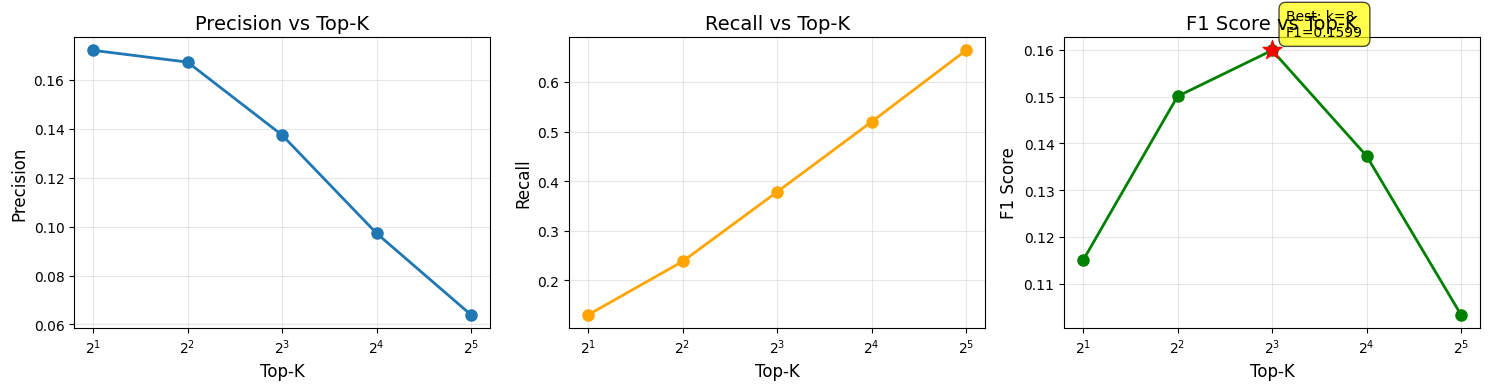


Best F1 Score: 0.1599 at Top-K = 8


In [28]:
# Visualize the results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot Precision
axes[0].plot(results_df['top_k'], results_df['precision'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Top-K', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision vs Top-K', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log', base=2)

# Plot Recall
axes[1].plot(results_df['top_k'], results_df['recall'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Top-K', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Recall vs Top-K', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log', base=2)

# Plot F1
axes[2].plot(results_df['top_k'], results_df['f1'], marker='o', linewidth=2, markersize=8, color='green')
axes[2].set_xlabel('Top-K', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].set_title('F1 Score vs Top-K', fontsize=14)
axes[2].grid(True, alpha=0.3)
axes[2].set_xscale('log', base=2)

# Mark best F1
best_idx = results_df['f1'].idxmax()
best_k = results_df.loc[best_idx, 'top_k']
best_f1 = results_df.loc[best_idx, 'f1']
axes[2].scatter([best_k], [best_f1], color='red', s=200, zorder=5, marker='*')
axes[2].annotate(f'Best: k={best_k}\nF1={best_f1:.4f}', 
                 xy=(best_k, best_f1), 
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print(f"\nBest F1 Score: {best_f1:.4f} at Top-K = {best_k}")